In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from sqlalchemy import MetaData
import numpy as np
import pandas as pd
import csv
from collections import defaultdict
import re
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from __future__ import division
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sqlalchemy import MetaData
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import settings
import time
import glob
import pickle

## Load working df into memory for use

In [263]:
def combine_pickles(tables):
    dflist = []
    count = 1
    for table in tables:
        print "\r","working on %s, %d/%d tables" % (table, count, len(tables)),
        filename = "../Pickles/backup/" + table + '.p'
        dflist.append(pickle.load(open(filename, 'rb')))
        count +=1
    df = pd.concat(dflist)
    dflist=None
    return df

In [265]:
# with open('../Pickles/final_patient_df.p') as f:
#     df = pickle.load(f)

df = combine_pickles(['short_final_df_0', 'short_final_df_1', 'short_final_df_2', 'short_final_df_3)

working on short_final_df_3, 4/4 tables


In [760]:
df.shape

(18097, 122)

### Create float of los in ICU 

In [1086]:
len(df[df.hospital_expire_flag == 1])

3428

In [268]:
# patient_df = pd.read_csv('../TextFiles/FINAL_patient_list.csv')
# patient_df = patient_df.drop(['Unnamed: 0', 'index', 'hadm_id, axis = 1)

In [269]:
df.los_icu = df.apply(lambda x: ((pd.Timestamp(x.outtime) - pd.Timestamp(x.intime))/np.timedelta64(1, 'D')).astype(float), axis = 1)

(0, 40)

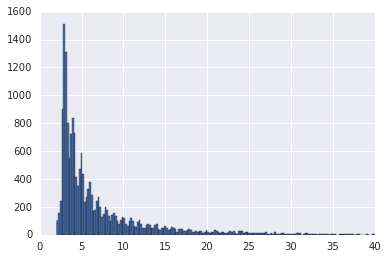

In [765]:
df.los_icu.hist(bins = 500)
plt.xlim(0, 40)

## Determine type of each column - time series, num, category, etc.

In [840]:
#Male = 1, Female = 0
df.replace('M', 1, inplace = True)
df.replace('F', 0, inplace = True)

In [841]:
#Get Feature Types into dictionary
#0 = ignore
#1 = numerical time series
#2 = purely categorical
#3 = numerical already
#4 = categorical time series
#5 = hold onto for now, drop when want to do model
import csv
featuretype_dict = {}
typefeature_dict = defaultdict(list)
reader = csv.reader(open('../TextFiles/feature_types.csv', 'r'))
d = {}
for k,v in reader:
    featuretype_dict[k] = int(v)
    typefeature_dict[int(v)].append(k)

In [858]:
# Have to rename resp rate separately since same name for columns in 44 and 45
column_names = list(df.columns)
column_names[44] = "Discard_RR"
df.columns = column_names

In [859]:
# Drop columns that we want to ignore (i.e. 0)
model_df = df.drop(typefeature_dict[0], axis = 1)
len(model_df.columns)

94

In [860]:
# One hot encoding for purely categorical
model_df = pd.get_dummies(model_df, columns = typefeature_dict[2])
len(model_df.columns)

136

In [880]:
print model_df.shape
print model_df[model_df.los_icu > 2].shape #LOS <2 (i.e. not cutting anything out)
print model_df[model_df.los_icu > 2.5].shape #LOS <3
print model_df[model_df.los_icu > 3].shape #LOS <4
print model_df[model_df.los_icu > 3.5].shape #LOS <5
print model_df[model_df.los_icu > 4].shape #LOS <5

(18097, 136)
(18097, 136)
(17776, 136)
(15531, 136)
(12943, 136)
(11265, 136)


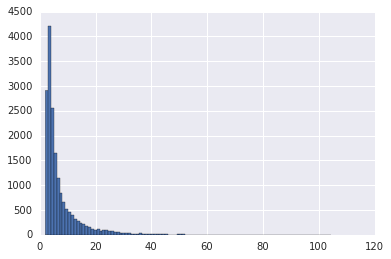

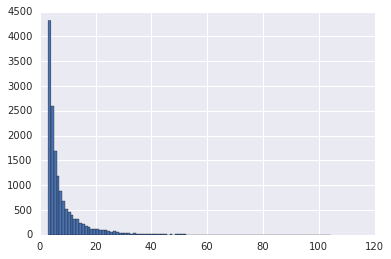

In [882]:
model_df.los_icu.hist(bins = 100)
plt.show()
model_df[model_df.los_icu > 3].los_icu.hist(bins = 100)

## Transform time series into particular values using function lists

In [1074]:
# Runs specific function for one patient over the time period specified in last x hours at hours_out
def get_measure(row, feature, function = None, last_x_hrs = 24, num_or_cat = 1, hours_out = 24, outlier_dict = {}):
    #print feature
    #print row 
    
    events_raw = row[feature]
    
    time_from_discharge = pd.Timestamp(row.outtime) - pd.Timedelta(str(hours_out) + "hours")
    #Get index in time series of when to start
    
    
    #i.e. not null
    if type(events_raw) == list and events_raw:
        events = np.array(events_raw)
        start_index = 0
        
        #Determines when you can start
        while ((start_index != len(events)) and (time_from_discharge < pd.Timestamp(events[start_index][0]))):
            start_index+=1
        
        ## Gets most recent     
        if function == None:
            if (((start_index != len(events))) and (time_from_discharge - pd.Timestamp(events[start_index][0])) < pd.Timedelta(str(last_x_hrs) + 'hours')):
                if(num_or_cat == 1):
                    if outlier_dict.get(feature) != None:
                        if (outlier_dict[feature][0] < events[start_index,2] < outlier_dict[feature][1]):
                            return float(events[start_index,2])
                    else:
                        return float(events[start_index,2])
                else:
                    return events[start_index,1]

        else:
            window = start_index
            #Gets x numbers before discharge time (assumes 24 hours before d/c time is not included/cleared)
            while(window != len(events) and (time_from_discharge - pd.Timestamp(events[window][0])) \
                  < pd.Timedelta(str(last_x_hrs) + 'hours')):
                window += 1

            ##array with values that are within x last hours
            if num_or_cat == 1:
                time_series = np.array(events[start_index:window,2]).astype(np.float)
                if outlier_dict.get(feature) != None:
                    time_series = time_series[(time_series > outlier_dict[feature][0]) & \
                                           (time_series < outlier_dict[feature][1])]
#                 if feature == 'Sodium' or feature == 'Temp' or feature == 'WBC':
#                     print "TIME_SERIES: ", time_series
                
#                 #print time_series
                
            else:
                time_series = np.array(events[start_index:window,1])
                
            if (time_series.size != 0):
#                 if feature == 'Sodium' or feature == 'Temp' or feature == 'WBC':
#                     print function, 
#                     print ": ", function(time_series)
                
                return function(time_series)

    return np.nan

In [1075]:
time_series = np.array(df.ix[1, "Sodium"])[0:15,2]
time_series = time_series.astype(np.float)
print time_series
time_series[(time_series > 80) & (time_series < 200)]

[ 129.  129.  131.  131.  134.  134.]


array([ 129.,  129.,  131.,  131.,  134.,  134.])

In [1076]:
## Runs list of functions on function list on all patients
def run_list_measures(df, feature, func_list, last_x_hrs = 24, num_or_cat = 1, hours_out = 24, outlier_dict = {}):
    for f in func_list:
        if f == None:
            df[str(feature) + '_most_recent'] = pd.Series()
            df[str(feature) + '_most_recent'] = df.apply(lambda x: get_measure(x,feature, None, last_x_hrs, 
                                                                               num_or_cat, hours_out, outlier_dict), axis = 1)
        else:
            df[str(feature) + '_' + f.__name__] = pd.Series()
            df[str(feature) + '_' + f.__name__] = df.apply(lambda x: get_measure(x,feature, f, last_x_hrs, 
                                                                                 num_or_cat, hours_out, outlier_dict), axis = 1)
    
    #drops original feature time series for modeling purposes
    ## COMMENT OUT if you want to hold onto time series
    df.drop(feature, axis = 1, inplace = True)
    return df

## Saving current model_df to pickle
- Note how much smaller it is now that we only have one value per cell.
- needs some work to cut out extraneous labels in categories like in ethnicity for example. 

In [1077]:
outlier_dict = {
'Sys_BP ':[20,400],
'PEEP':[0, 40],
'Heart_Rate':[0, 500],
'Mean_BP':[0, 400],
'Resp_Rate':[0, 100],
'SpO2':[0, 100],
'ALT':[0, 10000],
'AST':[0, 10000],
'Arterial_pH':[5, 9],
'Bicarbonate':[0, 80],
'Glucose':[0, 1400],
'Hematocrit':[0, 500],
'Hemoglobin':[0, 50],
'SaO2':[0, 100],
'BUN':[0, 400],
'Albumin':[0, 20],
'Calcium':[0, 20],
'Creatinine':[0, 80],
'INR':[0, 50],
'Lactic_Acid':[0, 100],
'Magnesium':[0, 20],
'Phosphorous':[0, 40],
'Potassium':[0, 12],
'Total_Bili':[0, 100],
'WBC':[0, 150],
'Dias_BP':[0, 300],
'Temp':[60, 120],
'Fi_O2':[0, 100],
'Sodium':[80, 200],
'Platelets':[0, 3000]
}

In [1078]:
feature_engineered_dict = {
'Sys_BP':[None, np.nanmedian, np.nanstd, nanrange], 
'PEEP':[None, np.nanmax],
'BSA':[None],
'CVP':[None, np.nanmax],
'Cardiac Index':[None],
'Cuff_Pressure':[None],
'ETT':[None],
'GCS_Eyes':[None, nanrange],
'Heart_Rate':[None, np.nanmedian, np.nanstd, nanrange],
'Resp_Pressure':[None],
'Minute_Volume':[None, np.nanmedian],
'GCS_Motor':[None, nanrange],
'Mean_BP':[None, np.nanmedian, np.nanstd, nanrange],
'O2_Flow':[None],
'PAP [Systolic]':[None],
'PCWP':[None],
'Plateau_Pressure':[None],
'Pressure_Support':[None],
'Resp_Rate':[None, np.nanmedian, np.nanstd, nanrange],
'SVR':[None],
'Tidal_Volume':[None],
'SpO2':[None, np.nanmedian, np.nanstd, nanrange],
'GCS_Verbal':[None, nanrange],
'Waveform-Vent':[None],
'Admit Wt':[None],
'ALT':[None, np.nanmedian, nanrange],
'AST':[None, np.nanmedian, nanrange],
'Alkaline_Phosphate':[None, np.nanmedian, nanrange],
'Arterial CO2(Calc)':[None],
'Arterial PaCO2':[None],
'Arterial PaO2':[None],
'Arterial_pH':[None, np.nanmin, np.nanmedian, nanrange],
'Bicarbonate':[None, np.nanmedian, nanrange],
'D-Dimer (0-500)':[None],
'Fibrinogen (150-400)':[None],
'Glucose':[None, np.nanmedian, nanrange],
'Hematocrit':[None, np.nanmedian, nanrange],
'Hemoglobin':[None, np.nanmedian, nanrange],
'LDH':[None, np.nanmedian, nanrange],
'RBC':[None, np.nanmedian, nanrange],
'SaO2':[None, np.nanmedian, np.nanstd, nanrange],
'Troponin':[None, np.nanmedian, nanrange],
'Vancomycin/Random':[None],
'BUN':[None, np.nanmedian, nanrange],
'Albumin':[None, np.nanmedian, nanrange],
'Calcium':[None, np.nanmedian, nanrange],
'Chloride':[None, np.nanmedian, nanrange],
'Creatinine':[None, np.nanmedian, nanrange],
'INR':[None, np.nanmedian, nanrange],
'Lactic_Acid':[None, np.nanmedian, np.nanmax, nanrange],
'Magnesium':[None, np.nanmedian, nanrange],
'Phosphorous':[None, np.nanmedian, nanrange],
'Potassium':[None, np.nanmedian, nanrange],
'Total_Bili':[None, np.nanmedian, nanrange],
'WBC':[None, np.nanmedian, nanrange],
'APRV_Pressure':[None],
'Dias_BP':[None, np.nanmedian, np.nanstd, nanrange],
'PAP [Diastolic]':[None],
'Central Venous Pressure':[None],
'Arterial O2 pressure':[None],
'Arterial O2 Saturation':[None],
'Arterial CO2 Pressure':[None],
'Temp':[None, np.nanmedian, np.nanstd, nanrange],
'Fi_O2':[None, np.nanmin],
'PSV_level':[None],
'CK':[None],
'TCO2 (calc) Arterial':[None],
'Sodium':[None, np.nanmedian, nanrange],
'Anion gap':[None],
'CPK/MB':[None],
'Platelets':[None, np.nanmedian, nanrange],
'Fibrinogen':[None, np.nanmedian]
}

In [1079]:
def nanrange(array):
    return np.nanmax(array) - np.nanmin(array)

In [1080]:
def run_all_windows_of_time(df, typefeature_dict, hours_out_list = [24, 36, 48, 60, 72], out_dict = {}, engineered_dict = {}):
    model_dfs_by_hour = []
    
    for hours_out in hours_out_list:
         # Drop columns that we want to ignore (i.e. 0)
        model_df = df.drop(typefeature_dict[0], axis = 1)
    
        # One hot encoding for purely categorical
        model_df = pd.get_dummies(model_df, columns = typefeature_dict[2])
   
        #Decrease patient subset to only include requisite amount of days out
        model_df = model_df[model_df.los_icu > (float(hours_out) + 24)/24]
    
        print "DF to predict %d hour mortality is starting." %hours_out
        print "   It has %d of patients." %len(model_df)
        
        counter = 0
        print "First numerical..."
        for x in typefeature_dict[1]:
            counter +=1
            model_transformed_df = run_list_measures(df = model_df, 
                                                     feature = x, 
                                                     func_list = engineered_dict[x], 
                                                     last_x_hrs = 24,
                                                     num_or_cat = 1, 
                                                     hours_out = hours_out, 
                                                    outlier_dict = out_dict)
            print '\r{0} %done'.format(counter/len(typefeature_dict[1])*100),
        counter = 0
        print "\nNow categorical..."
        for y in typefeature_dict[4]:
            counter +=1
            model_transformed_df = run_list_measures(df = model_transformed_df, 
                                                     feature = y,
                                                     func_list = [None], 
                                                     last_x_hrs = 24,
                                                     num_or_cat = 0, 
                                                     hours_out = hours_out)
            print '\r{0} %done'.format(counter/len(typefeature_dict[4])*100),
        categories = []
        for x in typefeature_dict[4]:
            categories.append(x+"_most_recent")
        #len(model_transformed_df.columns)
        #print model_transformed_df.columns
        service_series = model_transformed_df['Service Type_most_recent']
        
        model_transformed_df = pd.get_dummies(model_transformed_df, columns = categories)
        #  len(model_transformed_df.columns)
        model_transformed_df.to_pickle('../Pickles/' + str(hours_out) + '_out_model_df.p')
        model_dfs_by_hour.append(model_transformed_df)
        print "DF to predict %d hour mortality is complete." %hours_out
    return service_series, model_dfs_by_hour

In [1081]:
# model_dfs_by_hour = run_all_windows_of_time(df, typefeature_dict, hours_out_list= [168])
np.nanstd([10.7, 10.7])

0.0

In [1084]:
service_series, model_dfs_by_hour = run_all_windows_of_time(df, typefeature_dict, 
                                                            hours_out_list = [72, 168, 336], 
                                                            out_dict = outlier_dict,
                                                           engineered_dict = feature_engineered_dict)

DF to predict 72 hour mortality is starting.
   It has 11265 of patients.
First numerical...
100.0 %done 
Now categorical...
100.0 %done DF to predict 72 hour mortality is complete.
DF to predict 168 hour mortality is starting.
   It has 4924 of patients.
First numerical...
100.0 %done 
Now categorical...
100.0 %done DF to predict 168 hour mortality is complete.
DF to predict 336 hour mortality is starting.
   It has 1973 of patients.
First numerical...
100.0 %done 
Now categorical...
100.0 %done DF to predict 336 hour mortality is complete.


In [381]:
# def save_file_pickle(df, num_split):
#     length = len(df)
#     for i in range(num_split):
#         start_time = time.time()
#         filename = '../Pickles/backup/short_final_df_' + str(i) + '.p'
#         end = (i+1)*length/num_split
#         start = (i)*length/num_split
#         df[start:end].to_pickle(filename)
#         print '\r', time.time()-start_time, filename, 'done',

## Attempt at XGB

In [782]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [781]:
modelable_df = model_transformed_df.drop(list(typefeature_dict[5]), axis = 1)

In [788]:
model_column_names = list(modelable_df.columns)
model_column_names = [x.replace('<', "_LESS_") for x in model_column_names]
model_column_names = [x.replace('[', "") for x in model_column_names]
model_column_names = [x.replace(']', "") for x in model_column_names]
modelable_df.columns = model_column_names

In [789]:
X = modelable_df.drop(['hospital_expire_flag'], axis = 1)
y = modelable_df['hospital_expire_flag']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   test_size = 0.30)


In [790]:
#X.Heart_Rate_most_recent.hist(bins = 100)
#plt.xlim(xmin = 100, xmax = 180)

In [791]:
xgb_train = xgb.DMatrix(X_train, missing = np.nan, label = y_train)
xgb_test = xgb.DMatrix(X_test, missing = np.nan, label = y_test)
xgb_total = xgb.DMatrix(X, missing = np.nan, label = y)

In [792]:
params = {'booster': 'gbtree', 'max_depth': 3, 'eta':0.3, 'objective': 'binary:logistic'}

In [793]:
gbm = xgb.train(dtrain = xgb_train, params=params, num_boost_round = 10)

In [794]:
preds = gbm.predict(xgb_test)
pred_ALL = gbm.predict(xgb_total)

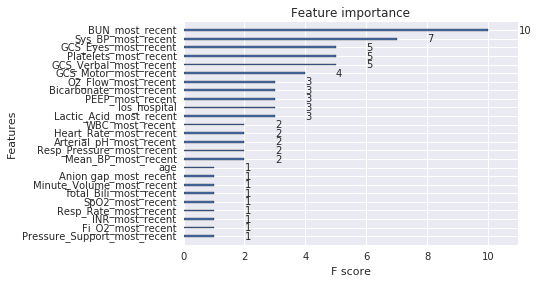

In [795]:
xgb.plot_importance(gbm)

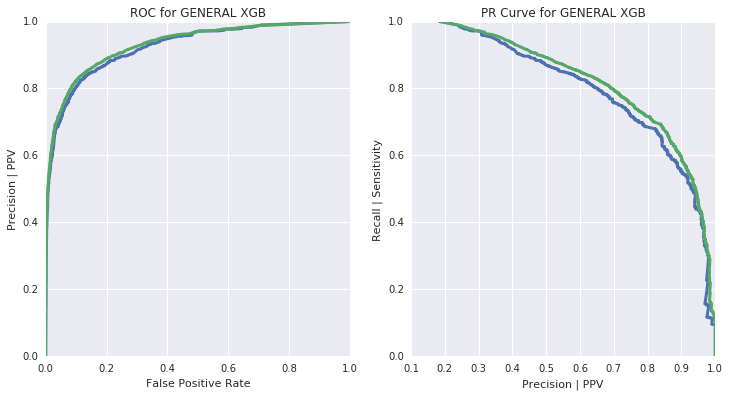

In [796]:
f, ax = plt.subplots(1, 2, figsize = (12, 6))
i = 0
roc = roc_curve(y_test, preds)
roc_ALL = roc_curve(y, pred_ALL)
ax[0].plot(roc[0],roc[1], linewidth = 3) 
ax[0].plot(roc_ALL[0],roc_ALL[1], linewidth = 3) 
ax[0].set_title('ROC for GENERAL XGB')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('Precision | PPV')

pr = precision_recall_curve(y_test, preds)
pr_ALL = precision_recall_curve(y, pred_ALL)
ax[1].plot(pr[0],pr[1], linewidth = 3) 
ax[1].plot(pr_ALL[0],pr_ALL[1], linewidth = 3) 
ax[1].set_title('PR Curve for GENERAL XGB')
ax[1].set_xlabel('Precision | PPV')
ax[1].set_ylabel('Recall | Sensitivity')

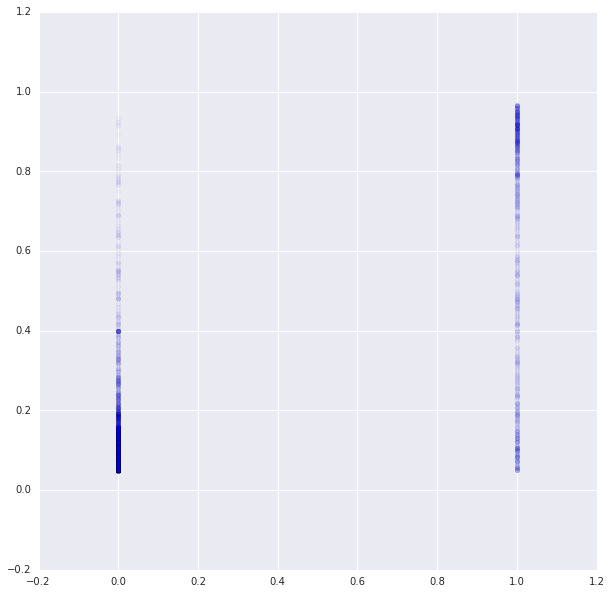

In [798]:
plt.figure(figsize= (10,10))
plt.scatter(y_test, preds, alpha = 0.03)

### Specifying XGB Classifier...

In [799]:
gbm_classifier = xgb.XGBClassifier()
gbm_classifier.fit(X_train, y_train)
#gbm_classifier.predict_proba(xgb_test)
y_pred_proba = gbm_classifier.predict_proba(X_test)[:,1]
y_pred_gbmC = gbm_classifier.predict(X_test)

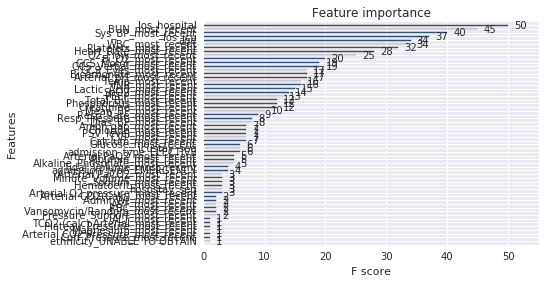

In [819]:
# ax, fig = plt.subplots(1, 1)
plot = plt.figure(figsize= (50,50))
x = xgb.plot_importance(gbm_classifier)

In [820]:
x

In [801]:
accuracy = accuracy_score(y_test, y_pred_gbmC)
print "The accuracy is: %0.4f" %accuracy
precision = precision_score(y_test, y_pred_gbmC)
print "The precision is: %0.4f" %precision
recall = recall_score(y_test, y_pred_gbmC)
print "The recall is: %0.4f" %recall
f1 = f1_score(y_test, y_pred_gbmC)
print "The f1 score is: %0.4f" %f1
print

The accuracy is: 0.9282
The precision is: 0.8966
The recall is: 0.6878
The f1 score is: 0.7784



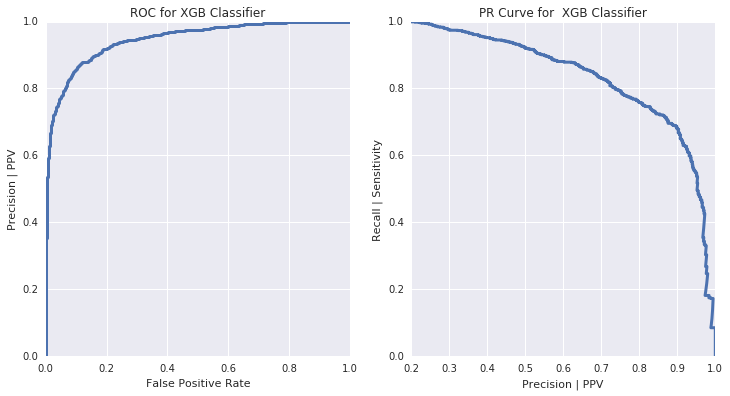

In [802]:
f, ax = plt.subplots(1, 2, figsize = (12, 6))
i = 0
roc = roc_curve(y_test, y_pred_proba)
ax[0].plot(roc[0],roc[1], linewidth = 3) 
ax[0].set_title('ROC for XGB Classifier')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('Precision | PPV')

pr = precision_recall_curve(y_test, y_pred_proba)
ax[1].plot(pr[0],pr[1], linewidth = 3) 
ax[1].set_title('PR Curve for  XGB Classifier')
ax[1].set_xlabel('Precision | PPV')
ax[1].set_ylabel('Recall | Sensitivity')

## K Nearest Neighbor Attempt

In [803]:
from sklearn.preprocessing import Imputer
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_X_train = imp.fit_transform(X_train)
imp_X_test = imp.transform(X_test)

In [804]:
# accuracy_scores = []
# for k in range(1, 11):
#     knear = KNeighborsClassifier(k)
#     knear.fit(imp_X_train, y_train)
#     y_pred_knn = knear.predict(imp_X_test)
#     acc = accuracy_score(y_test, y_pred_knn)
#     print("With {0} neighbors, the score was: {1}".format(k, acc))
#     accuracy_scores.append(acc)
# print acc
# print "\n The best k is %d with a score of %0.4f" %(accuracy_scores.index(max(accuracy_scores)) + 1,max(accuracy_scores))

With 1 neighbors, the score was: 0.802025782689
With 2 neighbors, the score was: 0.832965009208
With 3 neighbors, the score was: 0.833701657459
With 4 neighbors, the score was: 0.837753222836
With 5 neighbors, the score was: 0.837753222836
With 6 neighbors, the score was: 0.836464088398
With 7 neighbors, the score was: 0.840515653775
With 8 neighbors, the score was: 0.838305709024
With 9 neighbors, the score was: 0.842173112339
With 10 neighbors, the score was: 0.840515653775
0.840515653775

 The best k is 9 with a score of 0.8422


In [805]:
knear = KNeighborsClassifier(9)
knear.fit(imp_X_train, y_train)
y_pred_knn = knear.predict(imp_X_test)    
accuracy = accuracy_score(y_test, y_pred_knn)
print "The accuracy is: %0.4f" %accuracy
precision = precision_score(y_test, y_pred_knn)
print "The precision is: %0.4f" %precision
recall = recall_score(y_test, y_pred_knn)
print "The recall is: %0.4f" %recall
f1 = f1_score(y_test, y_pred_knn)
print "The f1 score is: %0.4f" %f1
print

The accuracy is: 0.8422
The precision is: 0.7220
The recall is: 0.2269
The f1 score is: 0.3453



In [806]:
# The accuracy is: 0.9249
# The precision is: 0.8865
# The recall is: 0.6885
# The f1 score is: 0.7751

## Attempt at Logistic Regression

In [807]:
lr = LogisticRegression()
lr_fit = lr.fit(imp_X_train, y_train)
y_pred_proba_lr = lr.predict_proba(imp_X_test)[:,1]
y_pred_lr = lr.predict(imp_X_test)

In [808]:
accuracy = accuracy_score(y_test, y_pred_lr)
print "The accuracy is: %0.4f" %accuracy
precision = precision_score(y_test, y_pred_lr)
print "The precision is: %0.4f" %precision
recall = recall_score(y_test, y_pred_lr)
print "The recall is: %0.4f" %recall
f1 = f1_score(y_test, y_pred_lr)
print "The f1 score is: %0.4f" %f1
print

# XGB Stats
# The accuracy is: 0.9249
# The precision is: 0.8865
# The recall is: 0.6885
# The f1 score is: 0.7751


The accuracy is: 0.9145
The precision is: 0.8428
The recall is: 0.6566
The f1 score is: 0.7381



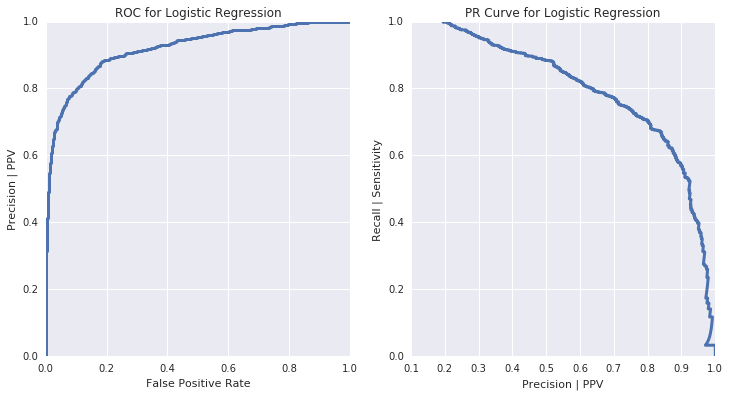

In [809]:
f, ax = plt.subplots(1, 2, figsize = (12, 6))
i = 0
roc = roc_curve(y_test, y_pred_proba_lr)
ax[0].plot(roc[0],roc[1], linewidth = 3) 
ax[0].set_title('ROC for Logistic Regression')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('Precision | PPV')

pr = precision_recall_curve(y_test, y_pred_proba_lr)
ax[1].plot(pr[0],pr[1], linewidth = 3) 
ax[1].set_title('PR Curve for Logistic Regression')
ax[1].set_xlabel('Precision | PPV')
ax[1].set_ylabel('Recall | Sensitivity')

In [810]:
lr_coef = zip(X_train.columns, lr.coef_[0])
lr_coef.sort(key = lambda x: abs(x[1]), reverse = True)
lr_coef

[('GCS_Eyes_most_recent', -0.5318594122979724),
 ('GCS_Motor_most_recent', -0.45534993210408009),
 ('GCS_Verbal_most_recent', -0.38222890275100596),
 ('PEEP_most_recent', 0.19369296766580624),
 ('icustay_seq', 0.17323257332581393),
 ('Hematocrit_most_recent', -0.1580974537376284),
 ('admission_type_EMERGENCY', 0.15621596060800616),
 ('Chloride_most_recent', -0.15179891824737862),
 ('Creatinine_most_recent', 0.15059526684075408),
 ('admission_type_ELECTIVE', -0.14479462376836721),
 ('hospstay_seq', 0.10837866627435305),
 ('CK_most_recent', -0.099756677632414539),
 ('Arterial O2 pressure_most_recent', 0.096382915484770834),
 ('Arterial_pH_most_recent', -0.081408543810143327),
 ('SpO2_most_recent', -0.077130320005102906),
 ('WBC_most_recent', 0.073489221494977566),
 ('Fi_O2_most_recent', 0.062915821662770224),
 ('PCWP_most_recent', -0.06269150516401191),
 ('Potassium_most_recent', 0.062013045390786323),
 ('Calcium_most_recent', -0.061395527121357402),
 ('Arterial O2 Saturation_most_recent

### Creating the scatter plot df
sorry it's disorganized

In [920]:
df['Service Type'].head()

0    [[2101-10-25 20:00:00, MICU, nan, ], [2101-10-...
1    [[2175-06-02 13:00:00, NSICU, nan, ], [2175-06...
2    [[2149-11-13 20:30:00, NSICU, nan, ], [2149-11...
3    [[2104-08-14 17:00:00, NSICU, nan, ], [2104-08...
4    [[2167-01-11 10:30:00, CSRU, nan, ], [2167-01-...
Name: Service Type, dtype: object

In [ ]:
visualization_df = model_transformed_df.copy()

In [ ]:
visualization_df['Prob_Mortality'] = pred_ALL

In [948]:
scatter_df = visualization_df[['Prob_Mortality', 'icustay_id', 'age', 'los_icu', 'hospital_expire_flag']]

In [949]:
scatter_df.round(decimals = 2)

,Prob_Mortality,icustay_id,age,los_icu,hospital_expire_flag
0,0.05,211552,76.52,6.06,0
1,0.11,228232,65.94,3.67,0
2,0.86,220597,41.79,5.32,1
3,0.13,232669,72.37,7.63,1
4,0.06,263738,39.86,3.67,0
5,0.85,216859,87.82,8.36,1
6,0.04,203487,58.95,3.55,0
7,0.83,254478,72.26,7.94,1
8,0.05,295037,45.51,7.69,0
9,0.05,282039,69.44,5.38,0


In [950]:
services_df = pd.read_pickle("../Pickles/services.p")

In [951]:
scatter_df = scatter_df.merge(services_df, on = 'icustay_id')

In [952]:
scatter_df

,Prob_Mortality,icustay_id,age,los_icu,hospital_expire_flag,first_careunit
0,0.051163,211552,76.5246,6.064560,0,MICU
1,0.106510,228232,65.9398,3.672917,0,SICU
2,0.855007,220597,41.7887,5.323056,1,MICU
3,0.128123,232669,72.3712,7.634815,1,SICU
4,0.055095,263738,39.8640,3.666042,0,CCU
5,0.850528,216859,87.8240,8.364722,1,MICU
6,0.044178,203487,58.9500,3.546574,0,CCU
7,0.827182,254478,72.2644,7.937940,1,MICU
8,0.051889,295037,45.5123,7.685417,0,TSICU
9,0.047776,282039,69.4416,5.375718,0,CSRU


In [953]:
scatter_df.to_csv("../TextFiles/scatter_df.csv")

In [657]:
brush_and_zoom = visualization_df[visualization_df.hospital_expire_flag == 1][['intime','hospital_expire_flag']]
brush_and_zoom.sort_values('intime', inplace=True)
brush_and_zoom['intime'] =  pd.to_datetime(brush_and_zoom['intime'], format='%Y-%m-%d %H:%M:%S')

per = brush_and_zoom.intime.dt.to_period("M")
month_year_df = brush_and_zoom.groupby(per).sum()

month_year_df = month_year_df.reset_index()

month_year_df.to_csv("../TextFiles/month_and_year.csv", index = False)

In [556]:
# pd.set_option('display.max_columns', len(model_transformed_df.head().columns))
# model_transformed_df.head()
    

In [557]:
# pd.reset_option('display.max_columns')